In [1]:
In [1]: import pandas as pd
In [2]: import matplotlib.pyplot as plt

In [3]: naive_times = pd.DatetimeIndex(start='2017', end='2018', freq='1h')

# very approximate
# latitude, longitude, name, altitude, timezone
coordinates = [(30, -110, 'Tucson', 700, 'Etc/GMT+7'),
(30, 10, 'Ghadames', 330, 'Etc/GMT-2'),
(32, 15, 'Misurata', 10, 'Etc/GMT-2'),
(33, 13, 'Tripoli', 33, 'Etc/GMT-2'),
(43, 141, 'Sapporo', 10, 'Etc/GMT-9'),
(50, 10, 'Berlin', 34, 'Etc/GMT-1'),
(-24, 69, 'Atacama', 2400, 'Etc/GMT-1')]

In [5]: import pvlib

# get the module and inverter specifications from SAM
In [6]: sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

In [7]: sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

In [8]: module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']

In [9]: inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208_208V__CEC_2014_']

# specify constant ambient air temp and wind for simplicity
In [10]: temp_air = 20

In [11]: wind_speed = 0

In [2]:
In [12]: system = {'module': module, 'inverter': inverter,
   ....:           'surface_azimuth': 180}
    

In [3]:
In [13]: energies = {}

In [14]: for latitude, longitude, name, altitude, timezone in coordinates:
   ....:     times = naive_times.tz_localize(timezone)
   ....:     system['surface_tilt'] = latitude
   ....:     solpos = pvlib.solarposition.get_solarposition(times, latitude, longitude)
   ....:     dni_extra = pvlib.irradiance.get_extra_radiation(times)
   ....:     airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
   ....:     pressure = pvlib.atmosphere.alt2pres(altitude)
   ....:     am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
   ....:     tl = pvlib.clearsky.lookup_linke_turbidity(times, latitude, longitude)
   ....:     cs = pvlib.clearsky.ineichen(solpos['apparent_zenith'], am_abs, tl,
   ....:                                  dni_extra=dni_extra, altitude=altitude)
   ....:     aoi = pvlib.irradiance.aoi(system['surface_tilt'], system['surface_azimuth'],
   ....:                                solpos['apparent_zenith'], solpos['azimuth'])
   ....:     total_irrad = pvlib.irradiance.get_total_irradiance(system['surface_tilt'],
   ....:                                                         system['surface_azimuth'],
   ....:                                                         solpos['apparent_zenith'],
   ....:                                                         solpos['azimuth'],
   ....:                                                         cs['dni'], cs['ghi'], cs['dhi'],
   ....:                                                         dni_extra=dni_extra,
   ....:                                                         model='haydavies')
   ....:     temps = pvlib.pvsystem.sapm_celltemp(total_irrad['poa_global'],
   ....:                                          wind_speed, temp_air)
   ....:     effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
   ....:         total_irrad['poa_direct'], total_irrad['poa_diffuse'],
   ....:         am_abs, aoi, module)
   ....:     dc = pvlib.pvsystem.sapm(effective_irradiance, temps['temp_cell'], module)
   ....:     ac = pvlib.pvsystem.snlinverter(dc['v_mp'], dc['p_mp'], inverter)
   ....:     annual_energy = ac.sum()
   ....:     energies[name] = annual_energy
   ....: 

C:\Users\Mhdella\Anaconda3\lib\site-packages\pvlib\pvsystem.py:1917: RuntimeWarning: invalid value encountered in maximum
  spectral_loss = np.maximum(0, np.polyval(am_coeff, airmass_absolute))


In [4]:
In [15]: energies = pd.Series(energies)

# based on the parameters specified above, these are in W*hrs
In [16]: print(energies.round(0))

Tucson      467728.0
Ghadames    462124.0
Misurata    462426.0
Tripoli     464865.0
Sapporo     476523.0
Berlin      383558.0
Atacama     540683.0
dtype: float64


Text(0,0.5,'Yearly energy yield (W hr)')

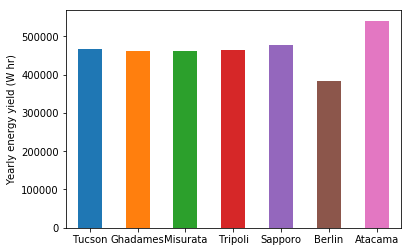

In [5]:
In [17]: energies.plot(kind='bar', rot=0)

In [18]: plt.ylabel('Yearly energy yield (W hr)')
